#DSPM HW2: Prediction and Clustering

Submitted by: mbatheja

In [1]:
#requirements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import openai
import json
from openai import OpenAI
import dotenv
from dotenv import load_dotenv
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    RocCurveDisplay
)

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [2]:
#Load dataset
df = pd.read_csv("telecom_customer_churn.csv")
df.head()

,viewer_id,gender,age,married,number_of_family_dependents,city,zip_code,latitude,longitude,number_of_referrals,...,subscription_type,paperless_billing,payment_method,monthly_charge,total_charges,total_refunds,total_extra_data_charges,total_long_distance_charges,total_revenue,viewer_status
0,0002-ORFBO,Female,37,Yes,0,SD,93225,34.827662,-118.999073,2,...,One Year,Yes,Credit Card,65.6,593.30,0.00,0,381.51,974.81,Stayed
1,0003-MKNFE,Male,46,No,0,SD,91206,34.162515,-118.203869,0,...,Month-to-Month,No,Credit Card,-4.0,542.40,38.33,10,96.21,610.28,Stayed
2,0004-TLHLJ,Male,50,No,0,SD,92627,33.645672,-117.922613,0,...,Month-to-Month,Yes,Bank Withdrawal,73.9,280.85,0.00,0,134.60,415.45,Churned
3,0011-IGKFF,Male,78,Yes,0,SD,94553,38.014457,-122.115432,1,...,Month-to-Month,Yes,Bank Withdrawal,98.0,1237.85,0.00,0,361.66,1599.51,Churned
4,0013-EXCHZ,Female,75,Yes,0,SD,93010,34.227846,-119.079903,3,...,Month-to-Month,Yes,Credit Card,83.9,267.40,0.00,0,22.14,289.54,Churned


##Step 0: Data Preparation

In [3]:
#data type
df.dtypes

,0
viewer_id,object
gender,object
age,int64
married,object
number_of_family_dependents,int64
city,object
zip_code,int64
latitude,float64
longitude,float64
number_of_referrals,int64


In [4]:
df.shape

(6588, 33)

In [5]:
# Data distribution
## Uniquely Values
unique_n = df.nunique().reset_index()
unique_n.columns = ['Column','Unique Count']
unique_n

,Column,Unique Count
0,viewer_id,6588
1,gender,2
2,age,62
3,married,2
4,number_of_family_dependents,10
5,city,4
6,zip_code,1626
7,latitude,1626
8,longitude,1625
9,number_of_referrals,12


In [6]:
#Missing values
missingness = round((df.isna().sum()/ len(df))*100, 2)
missingness

,0
viewer_id,0.00
gender,0.00
age,0.00
married,0.00
number_of_family_dependents,0.00
city,0.00
zip_code,0.00
latitude,0.00
longitude,0.00
number_of_referrals,0.00


In [7]:
#We are not dropping rows as the missingness represents customers without our internet service or those not opting for add-ons
## Creating NA is third category
df = df.fillna("NA")

In [8]:
# Summary stats
df.describe()

,age,number_of_family_dependents,zip_code,latitude,longitude,number_of_referrals,tenure_in_months,monthly_charge,total_charges,total_refunds,total_extra_data_charges,total_long_distance_charges,total_revenue
count,6588.000000,6588.000000,6588.000000,6588.000000,6588.000000,6588.000000,6588.000000,6588.000000,6588.000000,6588.000000,6588.000000,6588.000000,6588.000000
mean,46.757438,0.476169,93491.512750,36.199980,-119.757549,2.021099,34.494232,65.023915,2431.211611,2.081254,7.170613,798.101053,3234.402023
std,16.840793,0.968555,1857.716269,2.472582,2.155838,3.024220,23.966333,31.098217,2264.668413,8.125630,25.804970,853.832041,2854.047975
min,19.000000,0.000000,90001.000000,32.555828,-124.301372,0.000000,1.000000,-10.000000,18.850000,0.000000,0.000000,0.000000,21.610000
25%,33.000000,0.000000,92103.000000,33.989286,-121.790034,0.000000,12.000000,35.800000,544.362500,0.000000,0.000000,106.665000,835.407500
50%,46.000000,0.000000,93526.000000,36.245926,-119.601370,0.000000,32.000000,71.025000,1562.700000,0.000000,0.000000,472.240000,2375.925000
75%,60.000000,0.000000,95333.250000,38.169605,-117.967399,3.000000,57.000000,90.400000,3998.350000,0.000000,0.000000,1275.872500,5105.207500
max,80.000000,9.000000,96150.000000,41.962127,-114.192901,11.000000,72.000000,118.750000,8684.800000,49.790000,150.000000,3564.720000,11979.340000


In [9]:
# Outliers
print("---Monthly Charge ---")
# is TotalSales a normal distribution
mean_monthly = df['monthly_charge'].mean()
median_monthly = df['monthly_charge'].median()
mode_monthly = df['monthly_charge'].mode()[0]
print(f"mean value: {mean_monthly}, median_val: {median_monthly}, mode_val: {mode_monthly}")
##No it isn't, can't use z score
## IQR analysis
q1_monthly = df['monthly_charge'].quantile(0.25)
q3_monthly = df['monthly_charge'].quantile(0.75)
iqr_monthly = q3_monthly - q1_monthly
lower_bound_monthly = q1_monthly - 1.5 * iqr_monthly
upper_bound_monthly = q3_monthly + 1.5 * iqr_monthly

print(f"Q1: {q1_monthly:.2f}, Q3: {q3_monthly:.2f}, IQR: {iqr_monthly:.2f}")
print(f"Bounds: [{lower_bound_monthly:.2f}, {upper_bound_monthly:.2f}]")

outliers_monthly = df[(df["monthly_charge"] < lower_bound_monthly) | (df["monthly_charge"] > upper_bound_monthly)]
print(f"Potential outliers: {len(outliers_monthly)}")

---Monthly Charge ---
mean value: 65.0239146933819, median_val: 71.025, mode_val: 20.05
Q1: 35.80, Q3: 90.40, IQR: 54.60
Bounds: [-46.10, 172.30]
Potential outliers: 0


In [10]:
print("---Total Revenue ---")
# is TotalSales a normal distribution
mean_tr = df['total_revenue'].mean()
median_tr = df['total_revenue'].median()
mode_tr = df['total_revenue'].mode()[0]
print(f"mean value: {mean_tr}, median_val: {median_tr}, mode_val: {mode_tr}")
##No it isn't, can't use z score
## IQR analysis
q1_tr = df['total_revenue'].quantile(0.25)
q3_tr = df['total_revenue'].quantile(0.75)
iqr_tr = q3_tr - q1_tr
lower_bound_tr = q1_tr - 1.5 * iqr_tr
upper_bound_tr = q3_tr + 1.5 * iqr_tr

print(f"Q1: {q1_tr:.2f}, Q3: {q3_tr:.2f}, IQR: {iqr_tr:.2f}")
print(f"Bounds: [{lower_bound_tr:.2f}, {upper_bound_tr:.2f}]")

outliers_tr = df[(df['total_revenue'] < lower_bound_tr) | (df['total_revenue'] > upper_bound_tr)]
print(f"Potential outliers: {len(outliers_tr)}")

---Total Revenue ---
mean value: 3234.402023375835, median_val: 2375.925, mode_val: 24.8
Q1: 835.41, Q3: 5105.21, IQR: 4269.80
Bounds: [-5569.29, 11509.91]
Potential outliers: 9


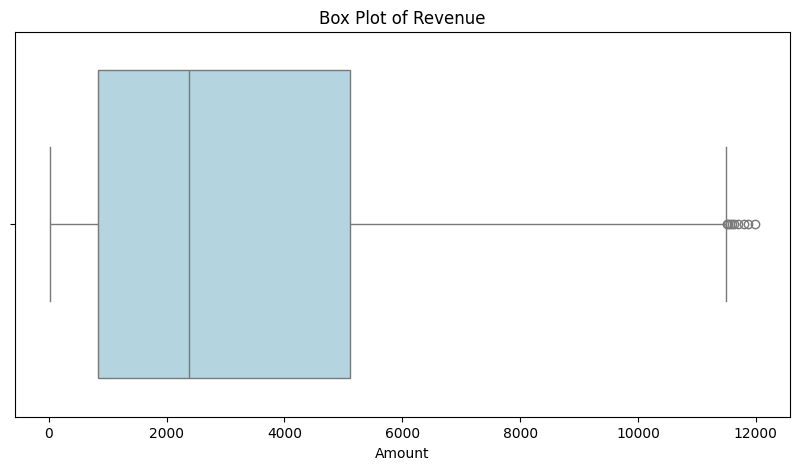

In [11]:
#Total Sales BoxPlot
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='total_revenue', color='lightblue')
plt.title('Box Plot of Revenue')
plt.xlabel('Amount')
plt.show()

In [12]:
#remove outliers
df = df[df['total_revenue']>= q1_tr - 1.5 * iqr_tr].copy()
df = df[df['total_revenue']<= q1_tr + 1.5 * iqr_tr].copy()
df.head(5)

,viewer_id,gender,age,married,number_of_family_dependents,city,zip_code,latitude,longitude,number_of_referrals,...,subscription_type,paperless_billing,payment_method,monthly_charge,total_charges,total_refunds,total_extra_data_charges,total_long_distance_charges,total_revenue,viewer_status
0,0002-ORFBO,Female,37,Yes,0,SD,93225,34.827662,-118.999073,2,...,One Year,Yes,Credit Card,65.6,593.30,0.00,0,381.51,974.81,Stayed
1,0003-MKNFE,Male,46,No,0,SD,91206,34.162515,-118.203869,0,...,Month-to-Month,No,Credit Card,-4.0,542.40,38.33,10,96.21,610.28,Stayed
2,0004-TLHLJ,Male,50,No,0,SD,92627,33.645672,-117.922613,0,...,Month-to-Month,Yes,Bank Withdrawal,73.9,280.85,0.00,0,134.60,415.45,Churned
3,0011-IGKFF,Male,78,Yes,0,SD,94553,38.014457,-122.115432,1,...,Month-to-Month,Yes,Bank Withdrawal,98.0,1237.85,0.00,0,361.66,1599.51,Churned
4,0013-EXCHZ,Female,75,Yes,0,SD,93010,34.227846,-119.079903,3,...,Month-to-Month,Yes,Credit Card,83.9,267.40,0.00,0,22.14,289.54,Churned


##Step 1: Exploratory Data Aanalysis & Data Preparation

In [13]:
#Churn rate by tenure bucket
labels = ['0-3 months', '4-6 months', '7-12 months', '13-24 months', '25-48 months', '49+ months']
bins = [-1,3,6,12,24,48,72]
df["tenure_bucket"] = pd.cut(df['tenure_in_months'], bins=bins, labels=labels)

##Groupby
viewer_status = {'Stayed':0, 'Churned':1}
churn = df.groupby("tenure_bucket")['viewer_status'].apply(lambda x: (x=="Churned").sum()/x.count()*100).reset_index()
churn.columns = ['Tenure Group', 'Churn Rate (%)']
churn

/tmp/ipython-input-502158792.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn = df.groupby("tenure_bucket")['viewer_status'].apply(lambda x: (x=="Churned").sum()/x.count()*100).reset_index()


,Tenure Group,Churn Rate (%)
0,0-3 months,100.000000
1,4-6 months,44.630072
2,7-12 months,35.335196
3,13-24 months,28.710938
4,25-48 months,20.351759
5,49+ months,7.051282


In [14]:
## churn versus add-ons
addon = ["internet_service","online_security","online_backup","device_protection_plan","premium_tech_support","unlimited_hi-res_streaming"]
df["add-ons"] = (df[addon] == "Yes").sum(axis=1)
addon_df = (df.groupby("viewer_status")['add-ons'].mean()).reset_index()
addon_df

,viewer_status,add-ons
0,Churned,2.542189
1,Stayed,2.545273


In [15]:
addons_df = (df.groupby(["tenure_bucket","viewer_status"])['add-ons'].mean()).reset_index()
addons_df

/tmp/ipython-input-10831554.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  addons_df = (df.groupby(["tenure_bucket","viewer_status"])['add-ons'].mean()).reset_index()


,tenure_bucket,viewer_status,add-ons
0,0-3 months,Churned,2.025126
1,0-3 months,Stayed,NaN
2,4-6 months,Churned,2.545455
3,4-6 months,Stayed,1.806034
4,7-12 months,Churned,2.466403
5,7-12 months,Stayed,2.015119
6,13-24 months,Churned,2.775510
7,13-24 months,Stayed,2.200000
8,25-48 months,Churned,3.154321
9,25-48 months,Stayed,2.720820


In [16]:
##Customer engagement on add-ons
addon_counts = (df[addon] == "Yes").agg(['sum', 'mean']).T.reset_index()
addon_counts.columns = ["Add_on", "Customers", "Total_%"]
addon_counts["Total_%"] = round(addon_counts["Total_%"]*100,2)
addon_churn_rates = []
for service in addon:
    users_of_service = df[df[service] == "Yes"]
    churn_count = (users_of_service['viewer_status'] == "Churned").sum()
    rate = (churn_count / len(users_of_service)) * 100 if len(users_of_service) > 0 else 0
    addon_churn_rates.append(round(rate, 2))


addon_counts["Churn_%"] = addon_churn_rates
addon_counts.sort_values(by="Churn_%", ascending=True)
addon_counts

,Add_on,Customers,Total_%,Churn_%
0,internet_service,4408.0,76.63,37.23
1,online_security,1478.0,25.70,17.05
2,online_backup,1723.0,29.95,25.71
3,device_protection_plan,1742.0,30.29,26.23
4,premium_tech_support,1481.0,25.75,17.56
5,unlimited_hi-res_streaming,3803.0,66.12,36.97


In [17]:
##Churn by contract type
churnXcontract = pd.crosstab(df['subscription_type'], df['viewer_status'], margins=True)
churnXcontract['Churn_pct'] = (churnXcontract['Churned']/churnXcontract['All'])*100
churnXcontract

viewer_status,Churned,Stayed,All,Churn_pct
subscription_type,,,,
Month-to-Month,1617,1484,3101,52.144470
One Year,118,1161,1279,9.225958
Two Year,19,1353,1372,1.384840
All,1754,3998,5752,30.493741


##Step 2: Customer Segmentation Using Clustering

In [18]:
candidates = df.iloc[:,1:-3]
candidates = candidates.drop(columns = ["zip_code", "lattitude", "longitude"], errors='ignore')
candidates.columns

Index(['gender', 'age', 'married', 'number_of_family_dependents', 'city',
       'latitude', 'number_of_referrals', 'tenure_in_months', 'offer',
       'internet_service', 'internet_type', 'avg_monthly_gb_download',
       'online_security', 'online_backup', 'device_protection_plan',
       'premium_tech_support', 'streaming_tv', 'streaming_movies',
       'streaming_music', 'unlimited_hi-res_streaming', 'subscription_type',
       'paperless_billing', 'payment_method', 'monthly_charge',
       'total_charges', 'total_refunds', 'total_extra_data_charges',
       'total_long_distance_charges', 'total_revenue'],
      dtype='object')

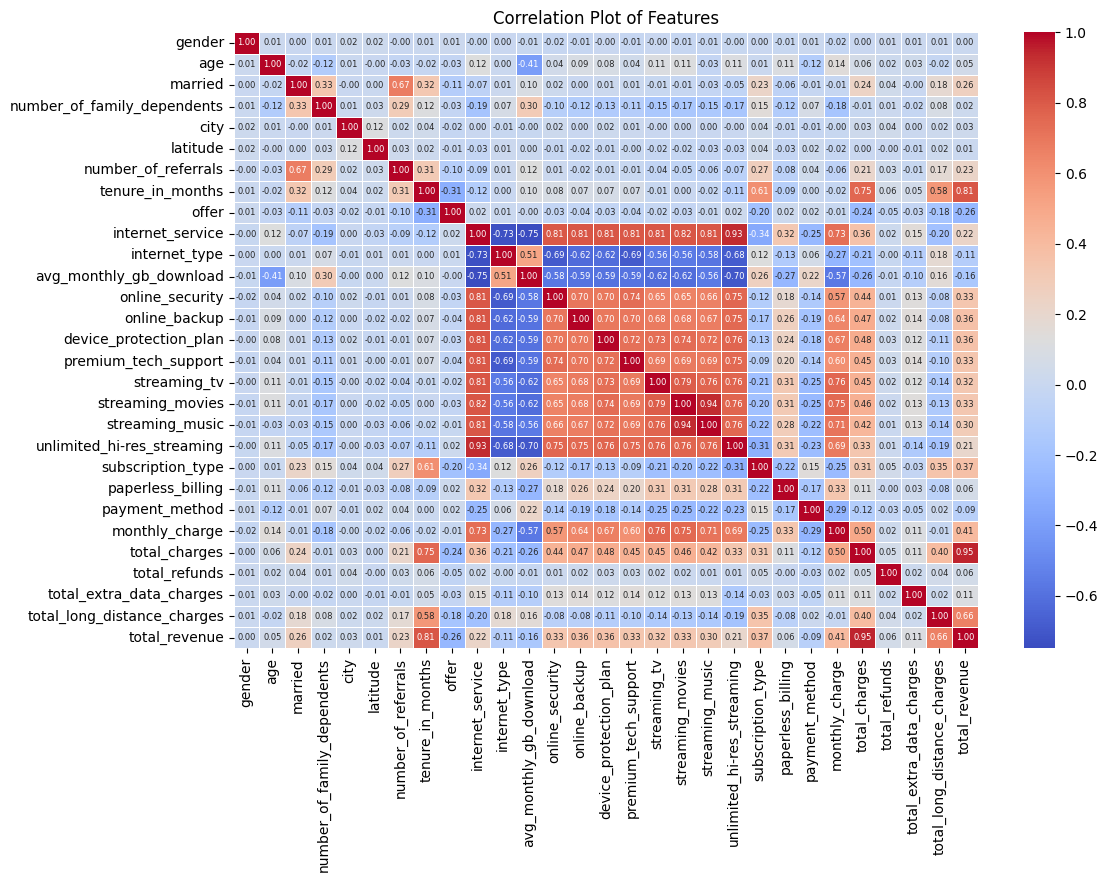

In [19]:
correlation = candidates.copy()

for col in correlation.select_dtypes(include=['object', 'category']).columns:
    correlation[col] = correlation[col].astype('category').cat.codes

## Calculate the correlation matrix
corr_matrix = correlation.corr()

## Plot correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix,
            annot=True,
            annot_kws={"size": 6},
            cmap='coolwarm',
            fmt=".2f",
            linewidths=0.5)

plt.title('Correlation Plot of Features')
plt.savefig('correlation_heatmap.png')

In [20]:
#VIF
# dropping
X_vif = add_constant(correlation)

vif_data = pd.DataFrame()
vif_data["candidate"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(len(X_vif.columns))]

print(vif_data.sort_values(by="VIF", ascending=False))



/usr/local/lib/python3.12/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


                      candidate         VIF
27     total_extra_data_charges         inf
25                total_charges         inf
29                total_revenue         inf
28  total_long_distance_charges         inf
26                total_refunds         inf
0                         const  333.824583
10             internet_service   33.806261
20   unlimited_hi-res_streaming   19.627248
18             streaming_movies   11.649657
19              streaming_music   10.683467
8              tenure_in_months    6.796935
24               monthly_charge    5.410046
11                internet_type    4.213662
17                 streaming_tv    4.073413
16         premium_tech_support    3.659389
13              online_security    3.608857
15       device_protection_plan    3.544734
14                online_backup    3.389265
12      avg_monthly_gb_download    3.135917
21            subscription_type    2.019141
3                       married    1.964149
7           number_of_referrals 

In [21]:
## final features (high VIF features and correlation features dropped)
features = correlation.drop(columns=['total_extra_data_charges', 'total_charges', 'total_long_distance_charges', 'total_refunds', 'internet_service', 'unlimited_hi-res_streaming', 'streaming_movies'])
# internet_services is highly correlated with internet type
features.columns


Index(['gender', 'age', 'married', 'number_of_family_dependents', 'city',
       'latitude', 'number_of_referrals', 'tenure_in_months', 'offer',
       'internet_type', 'avg_monthly_gb_download', 'online_security',
       'online_backup', 'device_protection_plan', 'premium_tech_support',
       'streaming_tv', 'streaming_music', 'subscription_type',
       'paperless_billing', 'payment_method', 'monthly_charge',
       'total_revenue'],
      dtype='object')

In [22]:
cluster_df = features.copy()
scaler_cluster = StandardScaler()
sc_cluster_df = scaler_cluster.fit_transform(cluster_df)

print(f"Clustering {cluster_df.shape[0]} viewers using {cluster_df.shape[1]} features")

Clustering 5752 viewers using 22 features


k=2: Silhouette Score = 0.293, Inertia = 92170.40
k=3: Silhouette Score = 0.184, Inertia = 81992.99
k=4: Silhouette Score = 0.157, Inertia = 78480.13
k=5: Silhouette Score = 0.139, Inertia = 75433.90
k=6: Silhouette Score = 0.100, Inertia = 72504.90
k=7: Silhouette Score = 0.102, Inertia = 70432.46
k=8: Silhouette Score = 0.101, Inertia = 68743.72


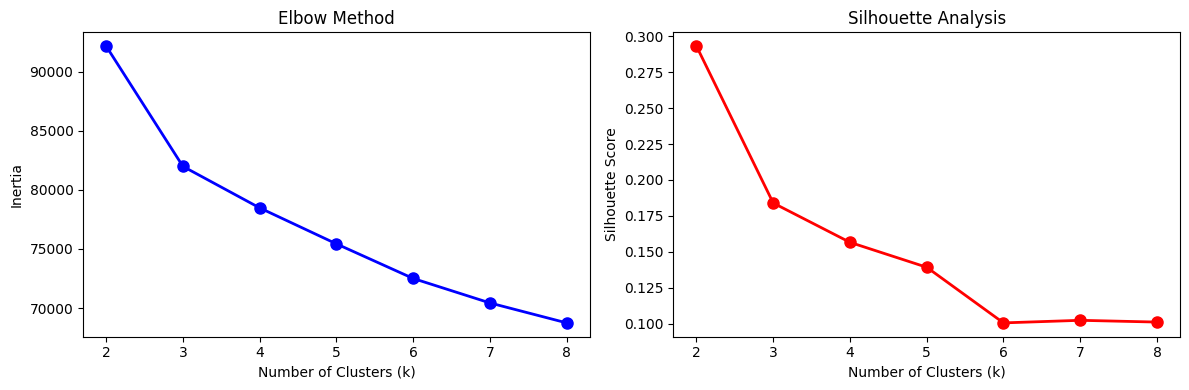

In [23]:
#Sillhoute Score for Different Ckuster sizes
k_values = [2, 3, 4, 5, 6, 7, 8]
sil_scores = []
inertias = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(sc_cluster_df)

    # Silhouette score
    score = silhouette_score(sc_cluster_df, labels)
    sil_scores.append(score)

    # Inertia for elbow method
    inertias.append(kmeans.inertia_)

    print(f"k={k}: Silhouette Score = {score:.3f}, Inertia = {kmeans.inertia_:.2f}")

# Combined dataframe
scores_df = pd.DataFrame({
    "k": k_values,
    "silhouette_score": sil_scores,
    "inertia": inertias
})

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Elbow plot
axes[0].plot(k_values, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Method')

# Silhouette plot
axes[1].plot(k_values, sil_scores, 'ro-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Analysis')

plt.tight_layout()
plt.show()

In [24]:
#segmentation
cluster_summaries = {}
k_opt = [2, 3, 4]

for k in k_opt:
    kmeans_opt = KMeans(n_clusters=k, random_state=42, n_init=10)
    col_name = f"{k}_clusters"
    df[col_name] = kmeans_opt.fit_predict(sc_cluster_df)

    print(f"\nCluster distribution for k={k}:")

    print(df[col_name].value_counts().sort_index())

    cluster_summaries[k] = df[col_name].value_counts().sort_index()

    # Compare churn rates across all experiments
    print(f"\nChurn rate for k={k}:",df.groupby(f'''{k}_clusters''')['viewer_status'].value_counts(normalize=True).unstack()['Churned'])



Cluster distribution for k=2:
2_clusters
0    1344
1    4408
Name: count, dtype: int64

Churn rate for k=2: 2_clusters
0    0.084077
1    0.372278
Name: Churned, dtype: float64

Cluster distribution for k=3:
3_clusters
0    1344
1    1866
2    2542
Name: count, dtype: int64

Churn rate for k=3: 3_clusters
0    0.084077
1    0.140943
2    0.542093
Name: Churned, dtype: float64

Cluster distribution for k=4:
4_clusters
0    1035
1    2160
2    1344
3    1213
Name: count, dtype: int64

Churn rate for k=4: 4_clusters
0    0.041546
1    0.589352
2    0.084077
3    0.267931
Name: Churned, dtype: float64


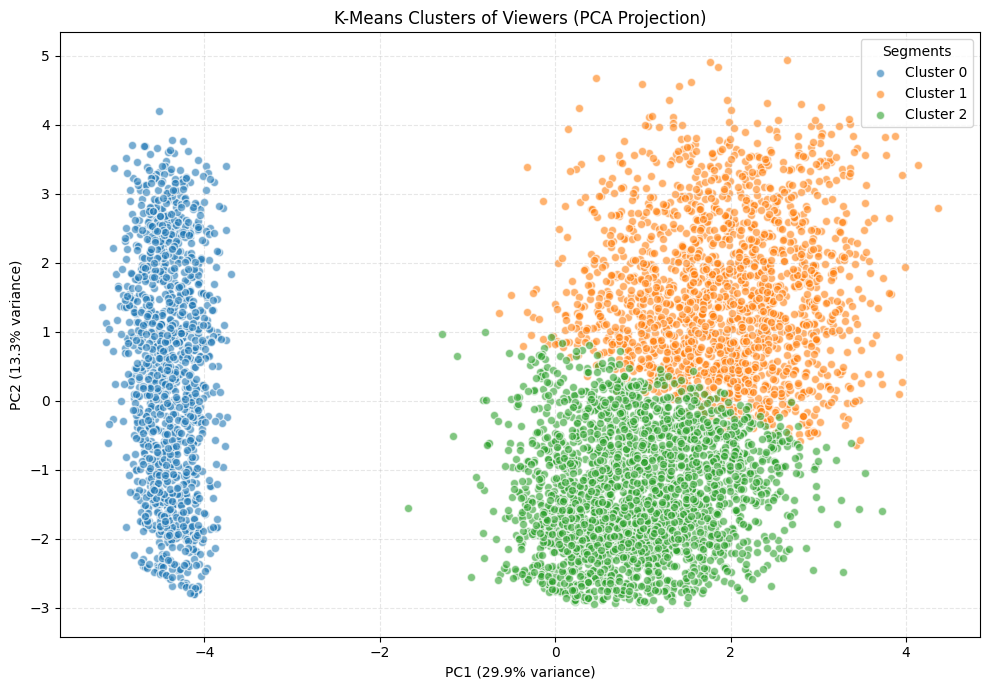

In [25]:
## PCA Visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(sc_cluster_df)
labels_k3 = df["3_clusters"].values

plt.figure(figsize=(10, 7))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for cluster_id in range(3):
    mask = labels_k3 == cluster_id
    plt.scatter(
        X_pca[mask, 0],
        X_pca[mask, 1],
        label=f"Cluster {cluster_id}",
        alpha=0.6,
        c=colors[cluster_id],
        edgecolors='w'
    )

plt.title("K-Means Clusters of Viewers (PCA Projection)")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)")
plt.legend(title="Segments")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

In [26]:
## selected cluster size k = 3
### Filter for numeric features
feature_names = features.columns.tolist() if hasattr(features, 'columns') else features
numeric_features = df[feature_names].select_dtypes(include=['number']).columns.tolist()
categorical_features = df[feature_names].select_dtypes(exclude=['number']).columns.tolist()

### Profile table for 3 clusters
for col in numeric_features:
  cp = {col: 'mean' for col in numeric_features}
for col in categorical_features:
  cp[col] = lambda x: x.mode()[0] if not x.mode().empty else "NA"

### Adding actual churn %
cluster_profile = df.groupby('3_clusters').agg(cp)
cluster_profile['churn_rate_%'] = df.groupby('3_clusters')['viewer_status'].apply(lambda x: (x == 'Churned').mean() * 100)

### Overall average
overall_stats = {}
for col in numeric_features:
    overall_stats[col] = df[col].mean()
for col in categorical_features:
    overall_stats[col] = df[col].mode()[0]

### Show profiles
profile = cluster_profile.T.round(3)
profile["Overall_Avg"] = pd.Series(overall_stats)
display(profile)

3_clusters,0,1,2,Overall_Avg
age,43.075893,47.39657,48.123525,46.708275
number_of_family_dependents,0.790923,0.571811,0.218725,0.466968
latitude,36.351142,36.265773,36.084297,36.20552
number_of_referrals,2.328125,3.167738,0.615264,1.843533
tenure_in_months,34.513393,47.801179,14.151849,29.825626
monthly_charge,20.712537,77.105493,68.373741,60.069984
total_revenue,1616.524077,4609.232497,1269.512514,2434.029383
gender,Male,Male,Female,Male
married,Yes,Yes,No,No
city,SD,SD,SD,SD


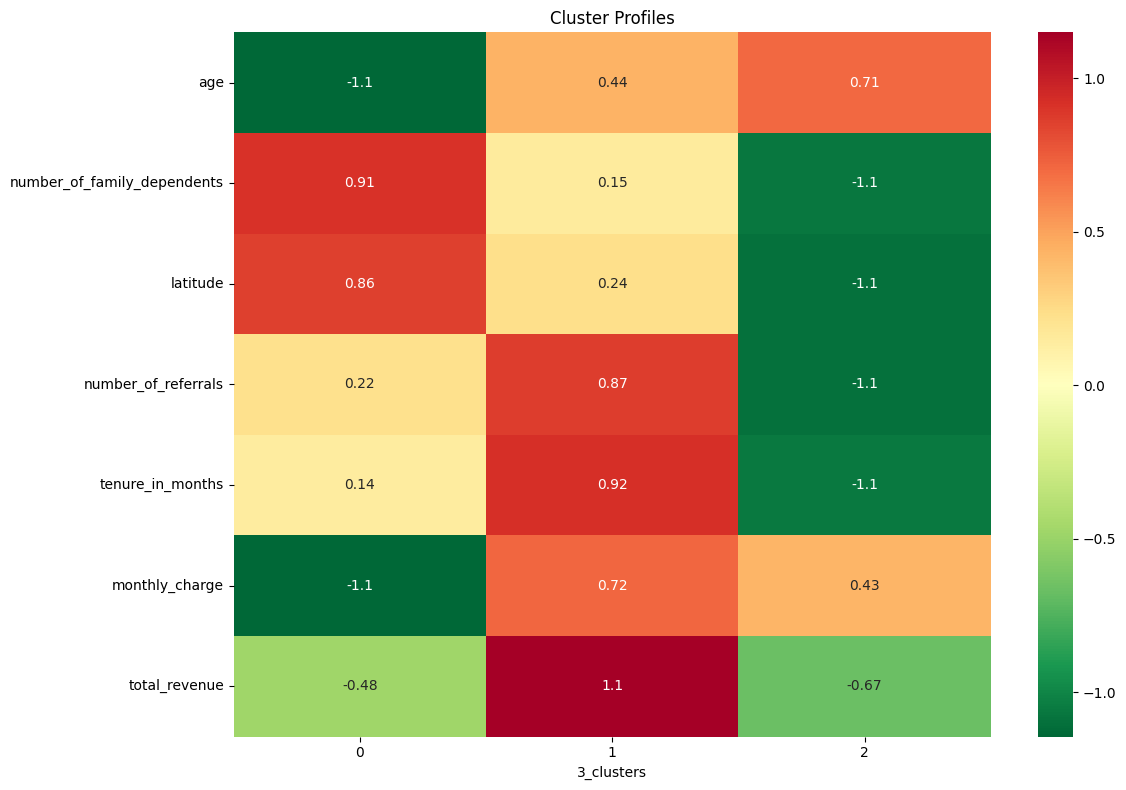

In [27]:
#plot
numeric_cols = df[features.columns].select_dtypes(include=['number']).columns.tolist()
cluster_means = df.groupby("3_clusters")[numeric_cols].mean()
cluster_normalized = (cluster_means - cluster_means.mean()) / cluster_means.std()

plt.figure(figsize=(12, 8))
sns.heatmap(cluster_normalized.T, annot=True, cmap='RdYlGn_r', center=0)
plt.title("Cluster Profiles")
plt.tight_layout()
plt.show()

##Step 3: Predictive Modelling

In [28]:
#splitting data
## Train test split (stratify to preserve class balance)
X = features.copy()
y = df['viewer_status'].map({'Churned': 1, 'Stayed': 0})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print(f"Training set: {X_train.shape[0]} viewers")
print(f"Test set: {X_test.shape[0]} viewers")
print(f"\nClass balance in test set: {y_test.mean():.1%} high churn rate")

Training set: 4026 viewers
Test set: 1726 viewers

Class balance in test set: 30.5% high churn rate


### 3.1 Baseline Model

In [29]:
## Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Logistic Regression Model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train)

# Predictions and predicted probabilities
y_pred_lr = log_reg.predict(X_test_scaled)
y_proba_lr = log_reg.predict_proba(X_test_scaled)[:, 1]

# Basic metrics
acc_lr = accuracy_score(y_test, y_pred_lr)
p_lr = precision_score(y_test, y_pred_lr)
r_lr = recall_score(y_test, y_pred_lr)
f_lr = f1_score(y_test, y_pred_lr)
auc_lr = roc_auc_score(y_test, y_proba_lr)

print(f"Logistic Regression accuracy: {acc_lr:.3f}")
print(f"Logistic Regression precision: {p_lr:.3f}")
print(f"Logistic Regression recall: {r_lr:.3f}")
print(f"Logistic Regression f1-score: {f_lr:.3f}")
print(f"Logistic Regression ROC AUC: {auc_lr:.3f}")

Logistic Regression accuracy: 0.843
Logistic Regression precision: 0.726
Logistic Regression recall: 0.778
Logistic Regression f1-score: 0.751
Logistic Regression ROC AUC: 0.908


In [30]:
print("Confusion matrix (Logistic Regression):")
print(confusion_matrix(y_test, y_pred_lr))

print("\nClassification report (Logistic Regression):")
print(classification_report(y_test, y_pred_lr, target_names=['Low Churn Rate', 'High Churn Rate']))

Confusion matrix (Logistic Regression):
[[1046  154]
 [ 117  409]]

Classification report (Logistic Regression):
                 precision    recall  f1-score   support

 Low Churn Rate       0.90      0.87      0.89      1200
High Churn Rate       0.73      0.78      0.75       526

       accuracy                           0.84      1726
      macro avg       0.81      0.82      0.82      1726
   weighted avg       0.85      0.84      0.84      1726



In [31]:
## Interpreting coefficients
coef_df = pd.DataFrame({
    "feature": features.columns.tolist(),
    "coefficient": log_reg.coef_[0]}).sort_values("coefficient", ascending=False)

print("Logistic Regression Coefficients:")
print("(Positive = increases risk of high churn rate)\n")
coef_df

Logistic Regression Coefficients:
(Positive = increases risk of high churn rate)



,feature,coefficient
2,married,0.801623
1,age,0.326386
20,monthly_charge,0.314609
15,streaming_tv,0.281808
16,streaming_music,0.235705
21,total_revenue,0.160520
18,paperless_billing,0.144175
13,device_protection_plan,0.132737
10,avg_monthly_gb_download,0.060867
12,online_backup,0.012072


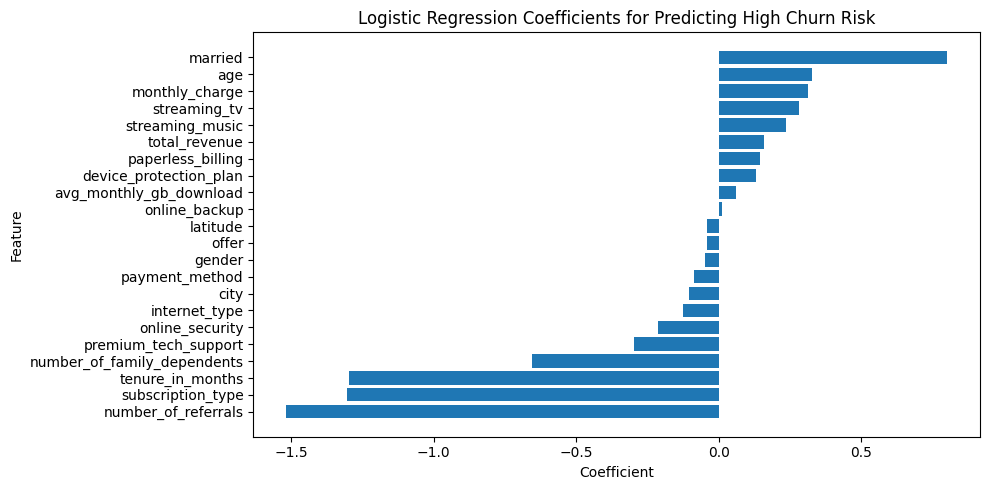

In [32]:
plt.figure(figsize=(10, 5))
plt.barh(coef_df["feature"], coef_df["coefficient"])
plt.xlabel("Coefficient")
plt.ylabel("Feature")
plt.title("Logistic Regression Coefficients for Predicting High Churn Risk")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### 3.2 Flexible Model

In [33]:
rf = RandomForestClassifier(
    n_estimators=20,
    random_state=42,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2
)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

acc_rf = accuracy_score(y_test, y_pred_rf)
p_rf = precision_score(y_test, y_pred_rf)
r_rf = recall_score(y_test, y_pred_rf)
f_rf = f1_score(y_test, y_pred_rf)
auc_rf = roc_auc_score(y_test, y_proba_rf)

print(f"Random Forest accuracy: {acc_rf:.3f}")
print(f"Random Forest accuracy: {p_rf:.3f}")
print(f"Random Forest accuracy: {r_rf:.3f}")
print(f"Random Forest accuracy: {f_rf:.3f}")
print(f"Random Forest ROC AUC: {auc_rf:.3f}")

Random Forest accuracy: 0.873
Random Forest accuracy: 0.843
Random Forest accuracy: 0.715
Random Forest accuracy: 0.774
Random Forest ROC AUC: 0.932


In [34]:
print("Confusion matrix (Random Forest):")
print(confusion_matrix(y_test, y_pred_rf))

print("\nClassification report (Random Forest):")
print(classification_report(y_test, y_pred_rf, target_names=['Low Churn Rate', 'High Churn Rate']))

Confusion matrix (Random Forest):
[[1130   70]
 [ 150  376]]

Classification report (Random Forest):
                 precision    recall  f1-score   support

 Low Churn Rate       0.88      0.94      0.91      1200
High Churn Rate       0.84      0.71      0.77       526

       accuracy                           0.87      1726
      macro avg       0.86      0.83      0.84      1726
   weighted avg       0.87      0.87      0.87      1726



In [35]:
importances = rf.feature_importances_
fi_df = pd.DataFrame({
    "feature": features.columns.tolist(),
    "importance": importances
}).sort_values("importance", ascending=False)

fi_df

,feature,importance
7,tenure_in_months,0.192871
17,subscription_type,0.174260
21,total_revenue,0.152716
6,number_of_referrals,0.080929
20,monthly_charge,0.065500
1,age,0.053031
10,avg_monthly_gb_download,0.037798
8,offer,0.034512
5,latitude,0.033293
3,number_of_family_dependents,0.026593


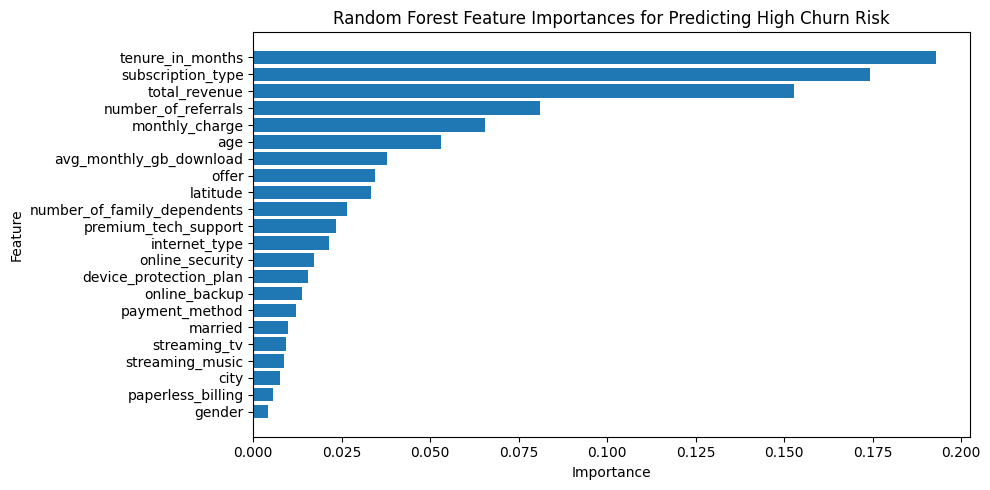

In [36]:
plt.figure(figsize=(10, 5))
plt.barh(fi_df["feature"], fi_df["importance"])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Random Forest Feature Importances for Predicting High Churn Risk")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### 3.3 ROC Curves Comparison

<Figure size 700x600 with 0 Axes>

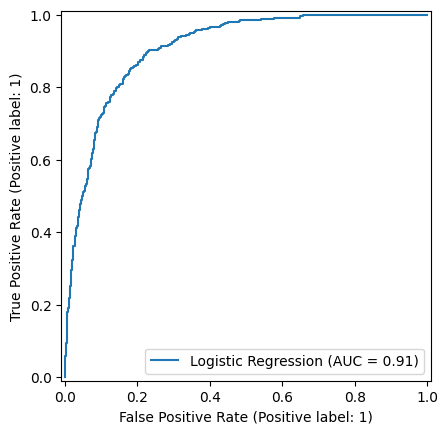

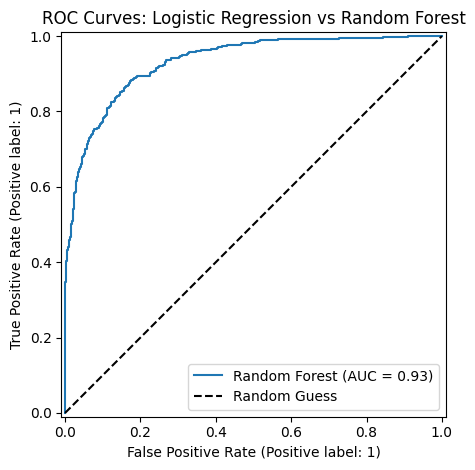

In [37]:
plt.figure(figsize=(7, 6))

RocCurveDisplay.from_predictions(y_test, y_proba_lr, name="Logistic Regression")
RocCurveDisplay.from_predictions(y_test, y_proba_rf, name="Random Forest")

plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.title("ROC Curves: Logistic Regression vs Random Forest")
plt.legend()
plt.tight_layout()
plt.show()

## Step 4: Revenue Risk & Retention Opportunity

In [38]:
# Both models have similar performance but random forest is slightly (although negligible) better on weighted average. Weighted average accuracy may be preferred as their is class imbalance
df['proba'] = rf.predict_proba(features)[:,1]
##Top 20%
df_sorted = df.sort_values(by="proba", ascending=False)
twenty_pct = int(len(df)*0.2)
high_churn = df_sorted.head(twenty_pct)
##Total Revenue
churner_revenue = high_churn['total_revenue'].sum()
print(f"Total Revenue from High Churn Rate Group (Top 20%): ${churner_revenue:,.2f}")

Total Revenue from High Churn Rate Group (Top 20%): $1,088,752.66


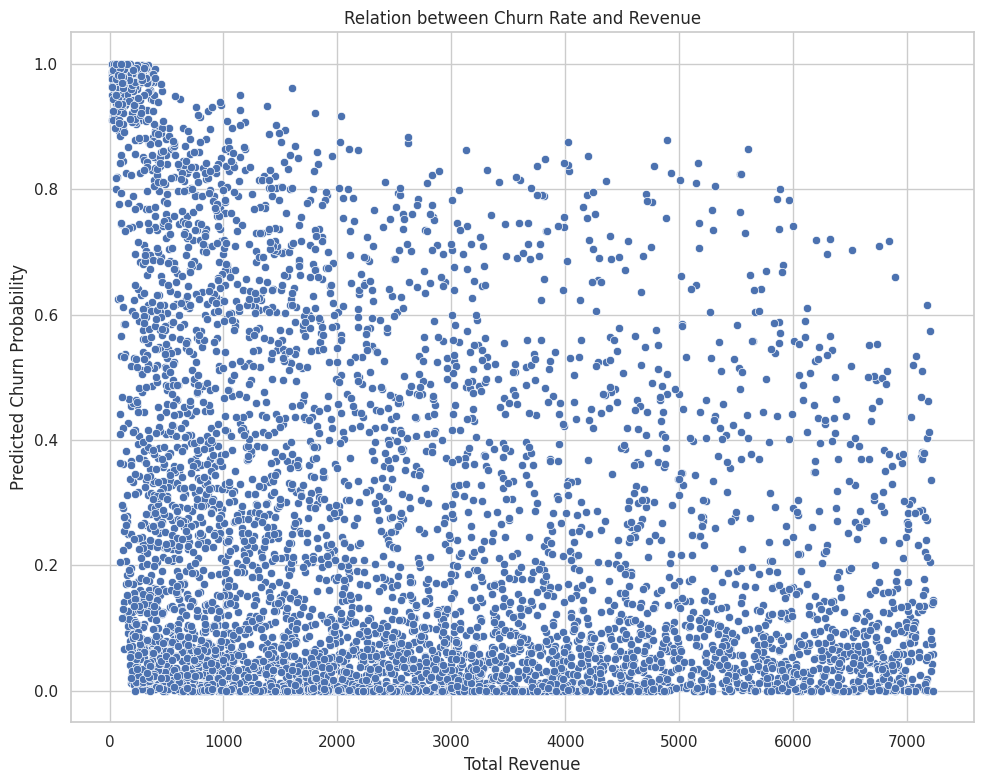

In [39]:
plt.figure(figsize=(10,8))
sns.set_theme(style="whitegrid")
sns.scatterplot(data= df,x='total_revenue',y='proba')
plt.title('Relation between Churn Rate and Revenue')
plt.xlabel('Total Revenue')
plt.ylabel('Predicted Churn Probability')
plt.tight_layout()
plt.show()

## Step 6: LLM Bonus

In [40]:
load_dotenv("/content/.env.txt")
CACHE_DIR = "cache"
os.makedirs(CACHE_DIR, exist_ok=True)

LLM_PATH = f"{CACHE_DIR}/churn_analysis.json"

In [41]:
def get_openai_client(): #create a .env file and set OPENAI_API_KEY="add your key here"
    api_key = os.environ.get("OPENAI_API_KEY")
    if not api_key:
        raise ValueError("OPENAI_API_KEY not found")
    return OpenAI(api_key=api_key)

def pattern_analysis(data_sample, model="gpt-4o-mini"):
    """
Input: subset of features dataset
Output: insights on viewer churn
    """
    # Load from cache if it exists to save API costs
    if os.path.exists(LLM_PATH):
        with open(LLM_PATH) as f:
            print("Loading analysis from cache...")
            return json.load(f)

    # Get the client using your existing helper
    client = get_openai_client()

    # Prompts for identifying patterns and make predictions
    system_prompt = f""" You are an expert business analyst at an internet and streaming service. You are able to predict churn probability by analysing the services viewers use, viewer demographics and their monthly charges.
    """
    user_prompt = f"""
I have this viewer data(Index is the Viewer ID): {data_sample}

Analyze the viewer characteristics, services used and billing and share your insights on churn and retention . Do not use statistical calculations.
- Generate 6-7 insights
- Do not repeat insights
Return ONLY a valid JSON object : {{insight1, insight2, insight3, insight4}}
Example: {{"Viewers with long tenures also use the most services and have low churn probability","Total revenue is lowest for those from San Diego and not streaming music"}}
"""

    # Call the LLM
    response = client.chat.completions.create(
        model=model,
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt}
        ],
        temperature=0.3,
        response_format={"type": "json_object"}
    )

    # Parse the result
    predictions = json.loads(response.choices[0].message.content)

    # Save to cache
    with open(LLM_PATH, "w") as f:
        json.dump(predictions, f, indent=2)

    return predictions


In [42]:
LLM_predicts = pattern_analysis(features[:81])

Loading analysis from cache...


In [43]:
LLM_predicts

{'insight1': 'Viewers who are married tend to have longer tenures and are less likely to churn compared to single viewers.',
 'insight2': 'Higher monthly charges are associated with a greater likelihood of churn, particularly among viewers with fewer family dependents.',
 'insight3': 'Viewers who utilize streaming music services show a lower churn probability, indicating a strong engagement with the platform.',
 'insight4': 'Those who opt for paperless billing exhibit higher retention rates, suggesting a preference for digital convenience.',
 'insight5': 'Viewers with a higher number of referrals tend to have longer tenures, indicating that social influence may play a role in retention.',
 'insight6': 'Younger viewers (under 30) have a higher churn probability, particularly if they are on lower-tier subscription plans.',
 'insight7': 'The use of premium tech support correlates with lower churn rates, suggesting that customers value assistance when encountering issues.'}